# Initial Dataset Discovery

In [2]:
import pyrfume

molecules = pyrfume.load_data("leffingwell/molecules.csv", remote=True)
behavior = pyrfume.load_data("leffingwell/behavior.csv", remote=True)

In [24]:
molecules.shape

(3523, 5)

In [3]:
behavior = behavior.set_index("IsomericSMILES")
behavior.head()

,alcoholic,aldehydic,alliaceous,almond,animal,anisic,apple,apricot,aromatic,balsamic,...,tobacco,tomato,tropical,vanilla,vegetable,violet,warm,waxy,winey,woody
IsomericSMILES,,,,,,,,,,,,,,,,,,,,,
CC(C)CC(C)(O)C1CCCS1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CCCCC=COC(=O)c1ccco1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CCCCC=COC(=O)C(C)CCC,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
CCCCC=COC(=O)CCCCCCCC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
CSCC[C@H](N)C(=O)OC(=O)CS,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As we begin to experiment with the dataset, let's see if we can reduce the problem. We begin by creating a subset of the chemicals with the most common smells.

In [8]:
top_scents = behavior.sum(axis=0).sort_values(ascending=False)
top_scents

fruity         1392
green           908
sweet           825
floral          553
fatty           407
               ... 
catty            20
musk             20
radish           20
leathery         20
horseradish      20
Length: 113, dtype: int64

Let's see how related these items are.

In [9]:
import seaborn as sns
import numpy as np

sns.set_theme()
sns.set(rc={"figure.figsize": (14, 10)})

In [10]:
co_occur = behavior.T.dot(behavior)

<AxesSubplot:>

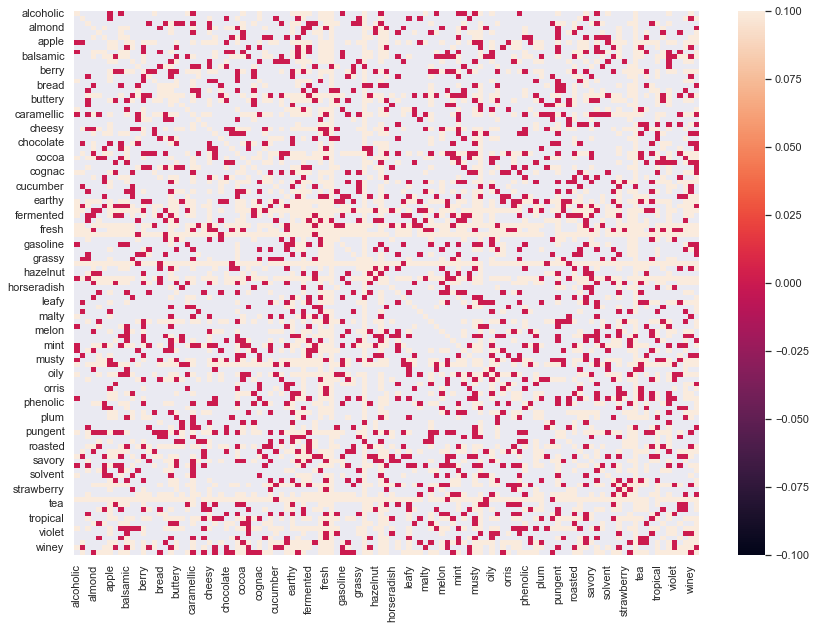

In [11]:
sns.heatmap(np.log(co_occur), fmt="d")

There are so many classes, many of which do not have many samples. Let's reduce this to a binary classification problem for initial training. This will speed up modelling process by decreases requried complexity of the model. A  multi-label classification model is equivalent to several binary classification models.

In [12]:
top_scents = top_scents.head(1)

In [13]:
behav_sub = behavior[top_scents.index]
behav_sub.head()

,fruity
IsomericSMILES,
CC(C)CC(C)(O)C1CCCS1,0
CCCCC=COC(=O)c1ccco1,1
CCCCC=COC(=O)C(C)CCC,1
CCCCC=COC(=O)CCCCCCCC,1
CSCC[C@H](N)C(=O)OC(=O)CS,0


In [14]:
top_scents.index

Index(['fruity'], dtype='object')

## Generate Dataset

In [15]:
from dataset import construct_dataset
from torch_geometric.loader import DataLoader

In [16]:
train_dataset, test_dataset = construct_dataset(behav_sub)

In [12]:
len(train_dataset), len(test_dataset)

(3171, 352)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# GNN Binary Graph Classification

## Train Model

In [14]:
import torch
from model import GCN, train, test, evaluate

torch.manual_seed(888)
np.random.seed(888)

In [15]:
num_node_features = len(train_dataset[0].x[0])
out_size = len(train_dataset[0].y)
model = GCN(num_node_features=num_node_features, hidden_channels=64, out_size=out_size)
print(model)

GCN(
  (conv1): TransformerConv(125, 64, heads=1)
  (conv2): TransformerConv(64, 64, heads=1)
  (conv3): TransformerConv(64, 64, heads=1)
  (conv4): TransformerConv(64, 64, heads=1)
  (conv5): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
  (activation): SELU()
  (out_activation): Sigmoid()
)


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(0, 101):
    train(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
    )
    if epoch % 5 == 0:
        train_acc = test(model=model, loader=train_loader)
        test_acc = test(model=model, loader=test_loader)
        print(
            f"Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

Epoch: 000, Train Acc: 0.7506, Test Acc: 0.7472
Epoch: 005, Train Acc: 0.7751, Test Acc: 0.7727
Epoch: 010, Train Acc: 0.7193, Test Acc: 0.7330
Epoch: 015, Train Acc: 0.6310, Test Acc: 0.6335
Epoch: 020, Train Acc: 0.7774, Test Acc: 0.7642
Epoch: 025, Train Acc: 0.7868, Test Acc: 0.7841
Epoch: 030, Train Acc: 0.7900, Test Acc: 0.7812
Epoch: 035, Train Acc: 0.8092, Test Acc: 0.7670
Epoch: 040, Train Acc: 0.8161, Test Acc: 0.7812
Epoch: 045, Train Acc: 0.8146, Test Acc: 0.7642
Epoch: 050, Train Acc: 0.8215, Test Acc: 0.7670
Epoch: 055, Train Acc: 0.8146, Test Acc: 0.7699
Epoch: 060, Train Acc: 0.8209, Test Acc: 0.7557
Epoch: 065, Train Acc: 0.8215, Test Acc: 0.7528
Epoch: 070, Train Acc: 0.8215, Test Acc: 0.7528
Epoch: 075, Train Acc: 0.8221, Test Acc: 0.7528
Epoch: 080, Train Acc: 0.8218, Test Acc: 0.7528
Epoch: 085, Train Acc: 0.8218, Test Acc: 0.7528
Epoch: 090, Train Acc: 0.8218, Test Acc: 0.7528
Epoch: 095, Train Acc: 0.8218, Test Acc: 0.7528
Epoch: 100, Train Acc: 0.8218, Test Acc:

## Model Evaluation

In [17]:
from metrics import get_eval_metrics

In [18]:
pred_y, actual_y = evaluate(model, test_loader)

In [19]:
get_eval_metrics(actual_y, pred_y, top_scents.index)

,class,precision,recall,TP,FP,TN,FN
0,fruity,0.68,0.723404,102,48,163,39


So, we can create a fair binary classifier with few parameters (few enough to train on a laptop CPU). Let's see if we can push the limit on how many classes we can predict on before we are required to scale our parameters.

# GNN Multi-label Graph Classification

In [23]:
behavior.sum(axis=0).sort_values(ascending=False).head(30)

fruity        1392
green          908
sweet          825
floral         553
fatty          407
herbal         406
sulfurous      252
waxy           244
apple          239
fresh          237
nutty          224
meaty          218
woody          211
spicy          203
citrus         201
tropical       201
oily           200
ethereal       195
roasted        195
winey          174
earthy         173
vegetable      165
balsamic       164
rose           163
caramellic     161
cheesy         142
pineapple      139
burnt          131
onion          125
mint           123
dtype: int64

In [20]:
top_scents = behavior.sum(axis=0).sort_values(ascending=False).head(5)
behav_sub = behavior[top_scents.index]
train_dataset, test_dataset = construct_dataset(behav_sub)
print(len(train_dataset), len(test_dataset))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

3171 352


In [21]:
behav_sub

,fruity,green,sweet,floral,fatty
IsomericSMILES,,,,,
CC(C)CC(C)(O)C1CCCS1,0,1,0,0,0
CCCCC=COC(=O)c1ccco1,1,1,1,0,0
CCCCC=COC(=O)C(C)CCC,1,1,0,0,0
CCCCC=COC(=O)CCCCCCCC,1,1,0,0,0
CSCC[C@H](N)C(=O)OC(=O)CS,0,0,1,0,0
...,...,...,...,...,...
CCCCCCOC(CCCCC)OCCCC,0,1,0,0,0
CCC1(C(O1)(C2=CC=CC=C2)C(=O)OCC)C,1,0,0,0,0
CCCCOC(=S)C(C)C,1,0,0,0,0


In [22]:
num_node_features = len(train_dataset[0].x[0])
out_size = train_dataset[0].y.shape[1]
model = GCN(num_node_features=num_node_features, hidden_channels=64, out_size=out_size)
print(model)

GCN(
  (conv1): TransformerConv(125, 64, heads=1)
  (conv2): TransformerConv(64, 64, heads=1)
  (conv3): TransformerConv(64, 64, heads=1)
  (conv4): TransformerConv(64, 64, heads=1)
  (conv5): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
  (activation): SELU()
  (out_activation): Sigmoid()
)


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(0, 101):
    train(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
    )
    if epoch % 5 == 0:
        train_acc = test(model=model, loader=train_loader)
        test_acc = test(model=model, loader=test_loader)
        print(
            f"Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

Epoch: 000, Train Acc: 0.3213, Test Acc: 0.2756
Epoch: 005, Train Acc: 0.3125, Test Acc: 0.2699
Epoch: 010, Train Acc: 0.3311, Test Acc: 0.2869
Epoch: 015, Train Acc: 0.3475, Test Acc: 0.2926
Epoch: 020, Train Acc: 0.3847, Test Acc: 0.3125
Epoch: 025, Train Acc: 0.4084, Test Acc: 0.3324
Epoch: 030, Train Acc: 0.4156, Test Acc: 0.3466
Epoch: 035, Train Acc: 0.4210, Test Acc: 0.3324
Epoch: 040, Train Acc: 0.4320, Test Acc: 0.3125
Epoch: 045, Train Acc: 0.4374, Test Acc: 0.3182
Epoch: 050, Train Acc: 0.4399, Test Acc: 0.3153
Epoch: 055, Train Acc: 0.4402, Test Acc: 0.3239
Epoch: 060, Train Acc: 0.4399, Test Acc: 0.3295
Epoch: 065, Train Acc: 0.4402, Test Acc: 0.3295
Epoch: 070, Train Acc: 0.4412, Test Acc: 0.3324
Epoch: 075, Train Acc: 0.4415, Test Acc: 0.3295
Epoch: 080, Train Acc: 0.4399, Test Acc: 0.3295
Epoch: 085, Train Acc: 0.4406, Test Acc: 0.3295
Epoch: 090, Train Acc: 0.4402, Test Acc: 0.3295
Epoch: 095, Train Acc: 0.4402, Test Acc: 0.3295
Epoch: 100, Train Acc: 0.4402, Test Acc:

In [24]:
pred_y, actual_y = evaluate(model, test_loader)
get_eval_metrics(actual_y, pred_y, top_scents.index)

,class,precision,recall,TP,FP,TN,FN
0,fruity,0.746667,0.741722,112,38,163,39
1,green,0.352381,0.587302,37,68,221,26
2,sweet,0.244186,0.677419,21,65,256,10
3,floral,0.327586,0.527778,19,39,277,17
4,fatty,0.357143,0.483871,15,27,294,16


We note the high relative number of true negatives and false positives in our dataset. 

Most likely this is due to the unbalanced dataset for several of the classes. Let's balance our dataset.

# Multi-Label GNN Classification - Balanced

In [25]:
top_scents = behavior.sum(axis=0).sort_values(ascending=False).head(5)
behav_sub = behavior[top_scents.index]
train_dataset, test_dataset = construct_dataset(behav_sub)
print(len(train_dataset), len(test_dataset))

3171 352


In [26]:
from dataset import get_balanced_sampler

In [27]:
train_sampler = get_balanced_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32)

In [28]:
num_node_features = len(train_dataset[0].x[0])
out_size = train_dataset[0].y.shape[1]
model = GCN(num_node_features=num_node_features, hidden_channels=64, out_size=out_size)
print(model)

GCN(
  (conv1): TransformerConv(125, 64, heads=1)
  (conv2): TransformerConv(64, 64, heads=1)
  (conv3): TransformerConv(64, 64, heads=1)
  (conv4): TransformerConv(64, 64, heads=1)
  (conv5): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=5, bias=True)
  (activation): SELU()
  (out_activation): Sigmoid()
)


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

for epoch in range(0, 101):
    train(
        model=model,
        loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
    )
    if epoch % 5 == 0:
        train_acc = test(model=model, loader=train_loader)
        test_acc = test(model=model, loader=test_loader)
        print(
            f"Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

Epoch: 000, Train Acc: 0.1022, Test Acc: 0.0426
Epoch: 005, Train Acc: 0.2293, Test Acc: 0.0852
Epoch: 010, Train Acc: 0.1186, Test Acc: 0.1847
Epoch: 015, Train Acc: 0.2365, Test Acc: 0.1648
Epoch: 020, Train Acc: 0.4147, Test Acc: 0.1903
Epoch: 025, Train Acc: 0.5320, Test Acc: 0.1903
Epoch: 030, Train Acc: 0.5383, Test Acc: 0.1932
Epoch: 035, Train Acc: 0.5465, Test Acc: 0.1960
Epoch: 040, Train Acc: 0.5853, Test Acc: 0.2301
Epoch: 045, Train Acc: 0.6228, Test Acc: 0.2188
Epoch: 050, Train Acc: 0.6332, Test Acc: 0.2244
Epoch: 055, Train Acc: 0.6414, Test Acc: 0.2131
Epoch: 060, Train Acc: 0.6235, Test Acc: 0.2386
Epoch: 065, Train Acc: 0.6238, Test Acc: 0.2188
Epoch: 070, Train Acc: 0.6304, Test Acc: 0.2301
Epoch: 075, Train Acc: 0.6175, Test Acc: 0.2131
Epoch: 080, Train Acc: 0.6194, Test Acc: 0.2131
Epoch: 085, Train Acc: 0.6361, Test Acc: 0.2102
Epoch: 090, Train Acc: 0.5963, Test Acc: 0.2131
Epoch: 095, Train Acc: 0.6427, Test Acc: 0.2102
Epoch: 100, Train Acc: 0.6436, Test Acc:

In [30]:
pred_y, actual_y = evaluate(model, test_loader)
get_eval_metrics(actual_y, pred_y, top_scents.index)

,class,precision,recall,TP,FP,TN,FN
0,fruity,0.706667,0.654321,106,44,146,56
1,green,0.580952,0.491935,61,44,184,63
2,sweet,0.593023,0.386364,51,35,185,81
3,floral,0.534483,0.369048,31,27,241,53
4,fatty,0.761905,0.450704,32,10,271,39


This performance looks much better after balancing our dataset. We noticed that we got much better performance when learning a single label. This hints that we should now scale up our architecture.